# Downloading Data

In [1]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash

!gcloud init

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0  24611      0 --:--:-- --:--:-- --:--:-- 24611
######################################################################## 100.0%
Running install script from: /tmp/tmp.AwtujqmRiT/install_google_cloud_sdk.bash
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
######################################################################## 100.0%

mkdir -p /root
"/root/google-cloud-sdk" already exists and may contain out of date files.
Remove /root/google-cloud-sdk or select a new installation directory, then run again.
Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
core:
  account: tobyzawthuhtet@gmail.com
  project: gicflood

Pick conf

In [3]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  44508      0 --:--:-- --:--:-- --:--:-- 44508
OK
61 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.40.0).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.


In [5]:
%cd /home
!sudo mkdir checkpoints

/home
mkdir: cannot create directory ‘checkpoints’: File exists


In [6]:
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv .

Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      


In [7]:
!sudo mkdir files
!sudo mkdir files/S1
!sudo mkdir files/Labels

!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand files/S1
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand files/Labels


mkdir: cannot create directory ‘files’: File exists
mkdir: cannot create directory ‘files/S1’: File exists
mkdir: cannot create directory ‘files/Labels’: File exists
Building synchronization state...
Starting synchronization...
Building synchronization state...
Starting synchronization...


In [8]:
!ls

checkpoints  flood_test_data.csv   loss.py     Preds
dataset.py   flood_train_data.csv  metrics.py  Preds.zip
files	     flood_valid_data.csv  models.py   __pycache__


# EDA Part

In [9]:
import tifffile as tfl
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import keras as k
from tensorflow import keras
import os

(2, 512, 512) (512, 512)


Text(0.5, 1.0, 'Label data')

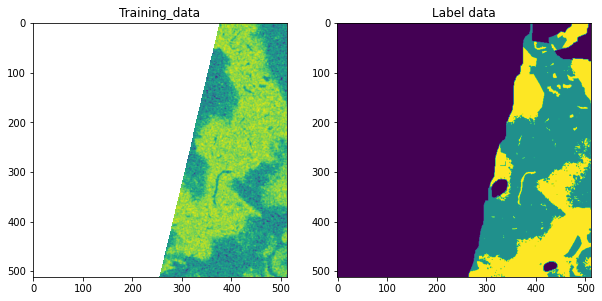

In [10]:
n = np.random.randint(1,100)

train = tfl.imread('/home/files/S1/Bolivia_103757_S1Hand.tif')

label = tfl.imread('/home/files/Labels/Bolivia_103757_LabelHand.tif')

print(train.shape,label.shape)

fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
ax1.imshow(train[1])
ax1.set_title('Training_data')
ax2.imshow(label)
ax2.set_title('Label data')

# Prepare Data and Load Model

# Data Loader

In [11]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class BuildingDataset(keras.utils.Sequence):
    """
    Sequence class to load & vectorize batches of data.
    
    Iterate over the data (as Numpy arrays).
    
    Reference - https://keras.io/examples/vision/oxford_pets_image_segmentation/#prepare-sequence-class-to-load-amp-vectorize-batches-of-data
    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # load images
        x = np.zeros((self.batch_size,) + self.img_size + (2,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = tfl.imread(path)
            img[np.where(np.isnan(img))] = 0
            
            img = np.moveaxis(img,0,2)
        

            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size+ (1,) , dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            mask = tfl.imread(path)
            mask[np.where(np.isnan(mask))] = 0
            mask[mask == -1 ]= 0
            mask= np.expand_dims(mask,-1)

            y[j] = mask  
            # print(np.unique(y[j]))
            
        return x, y

In [15]:
# make lists for image and mask directories
import glob

images_dir = '/home/files/S1'
masks_dir = '/home/files/Labels'

image_paths = sorted(glob.glob(f'{images_dir}/*'))
mask_paths = sorted(glob.glob(f'{masks_dir}/*'))

print(f'total images: {len(image_paths)}')
print(f'total masks: {len(mask_paths)}')
print(image_paths[:5])
print(mask_paths[:5])

import random



total images: 446
total masks: 446
['/home/files/S1/Bolivia_103757_S1Hand.tif', '/home/files/S1/Bolivia_129334_S1Hand.tif', '/home/files/S1/Bolivia_195474_S1Hand.tif', '/home/files/S1/Bolivia_23014_S1Hand.tif', '/home/files/S1/Bolivia_233925_S1Hand.tif']
['/home/files/Labels/Bolivia_103757_LabelHand.tif', '/home/files/Labels/Bolivia_129334_LabelHand.tif', '/home/files/Labels/Bolivia_195474_LabelHand.tif', '/home/files/Labels/Bolivia_23014_LabelHand.tif', '/home/files/Labels/Bolivia_233925_LabelHand.tif']


# Creating Training Data and Validation Data

In [17]:
# number of validation samples
val_samples = 50

random.Random(1337).shuffle(image_paths)
random.Random(1337).shuffle(mask_paths)

# Split our img paths into a training and a validation set
train_image_paths = image_paths[:-val_samples]
train_mask_paths = mask_paths[:-val_samples]

val_image_paths = image_paths[-val_samples:]
val_mask_paths = mask_paths[-val_samples:]



# Instantiate data Sequences for each split

# from dataset import FllodDataset

img_size = (512, 512)
batch_size = 16

train_gen = BuildingDataset(batch_size,
                            img_size,
                            train_image_paths,
                            train_mask_paths)

val_gen = BuildingDataset(batch_size,
                          img_size,
                          val_image_paths,
                          val_mask_paths)

# Loading Model

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from loss import bce_dice_loss, dice_coef
from metrics import recall_m,precision_m,f1_m

activation_function = 'sigmoid'
num_classes = 1
#num_classes =3 
#activation_function = 'softmax'


from models import UNet
model = UNet(num_classes = num_classes,
         image_size = 512, 
         img_channels = 2,
         activation_fn = 'sigmoid')

# from models import DeepUNet
# model =  DeepUNet(num_classes=num_classes,
#              image_size=512,
#              img_channels=2,
#              activation_fn = 'sigmoid',
#              )
#// Cannot test DeepNet Model yet : Error (ResourceExhaustedError: Graph execution error:)

loss = bce_dice_loss # can use 'binary_crossentropy'
optimizer = Adam()

# compile model
model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = [recall_m, 
                        precision_m, 
                        f1_m])

In [19]:
# Tesing with sample model to check input shape and output shape
# x,y = train_gen[0]
# x.shape,y.shape

# test = model.predict(x)
# test.shape,y.shape

#Training Model

In [20]:
# Train the model, doing validation at the end of each epoch.
epochs = 100

history = model.fit(train_gen, 
          epochs=epochs, 
          validation_data=val_gen,
          verbose = 1)

Epoch 1/100
24/24 [==============================] - 44s 1s/step - loss: 0.7021 - recall_m: 0.0661 - precision_m: 0.1209 - f1_m: 0.0695 - val_loss: 0.6869 - val_recall_m: 0.0515 - val_precision_m: 0.2449 - val_f1_m: 0.0820
Epoch 2/100
24/24 [==============================] - 30s 1s/step - loss: 0.6763 - recall_m: 0.0623 - precision_m: 0.2324 - f1_m: 0.0919 - val_loss: 0.6340 - val_recall_m: 0.4914 - val_precision_m: 0.2400 - val_f1_m: 0.3084
Epoch 3/100
24/24 [==============================] - 30s 1s/step - loss: 0.6358 - recall_m: 0.2105 - precision_m: 0.2584 - f1_m: 0.2170 - val_loss: 0.6019 - val_recall_m: 0.1051 - val_precision_m: 0.4827 - val_f1_m: 0.1660
Epoch 4/100
24/24 [==============================] - 30s 1s/step - loss: 0.6133 - recall_m: 0.2327 - precision_m: 0.3305 - f1_m: 0.2383 - val_loss: 0.5561 - val_recall_m: 0.2344 - val_precision_m: 0.5217 - val_f1_m: 0.3096
Epoch 5/100
24/24 [==============================] - 30s 1s/step - loss: 0.5999 - recall_m: 0.2713 - precisi

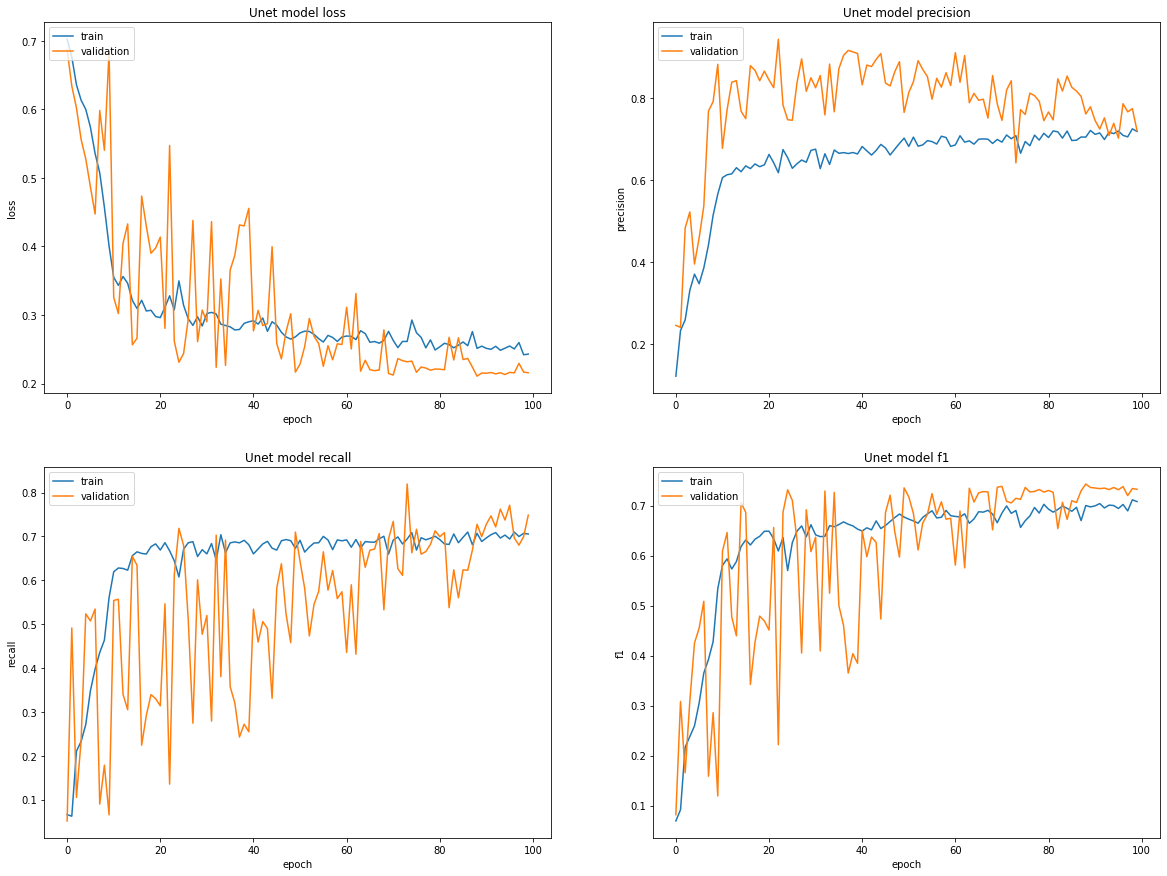

In [21]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')



In [34]:
loss1,recall,precision,f1 = model.evaluate(val_gen,verbose=0)
print(f"Unet \nprecision :{precision*100} \nf1 score :{f1*100} \nrecall :{recall*100} \nLoss :{loss}")

Unet 
precision :72.02844619750977 
f1 score :73.25286865234375 
recall :74.87762570381165 
Loss :<function bce_dice_loss at 0x7fc179525c20>


## Model Inferencing

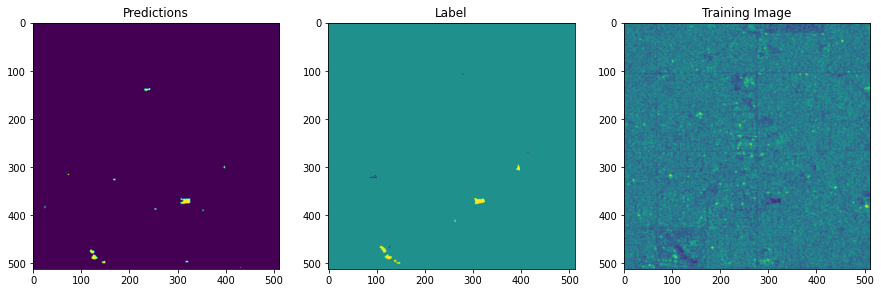

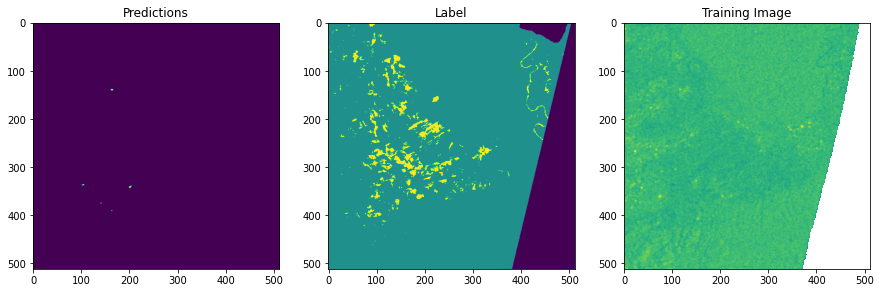

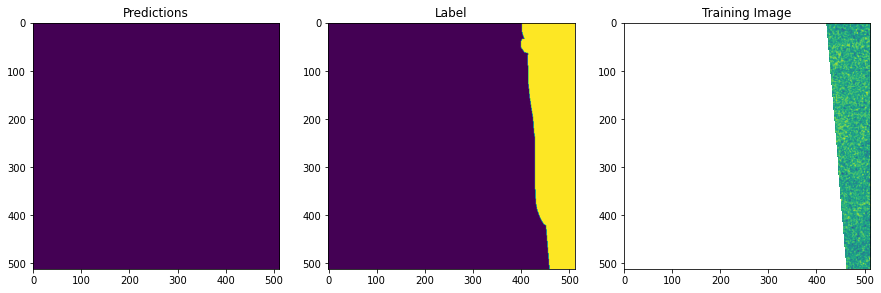

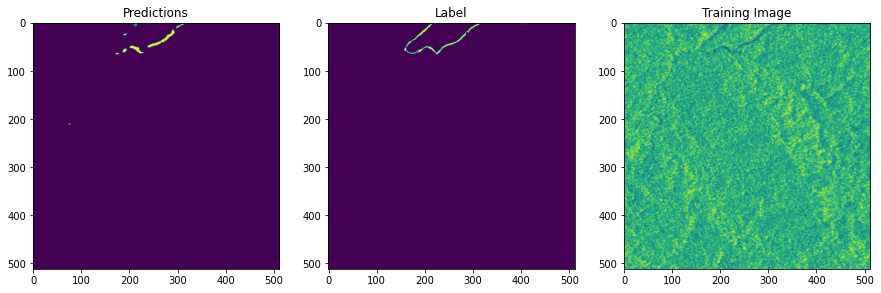

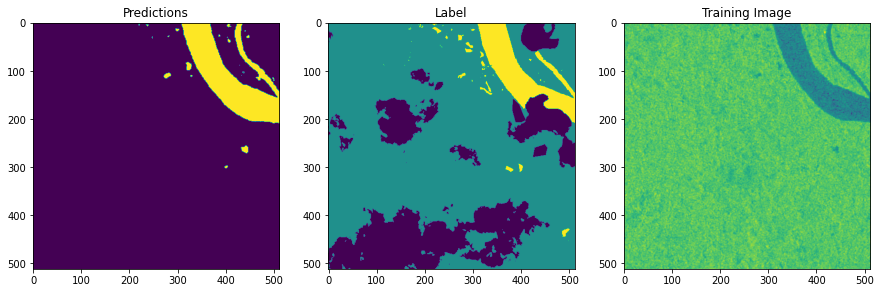

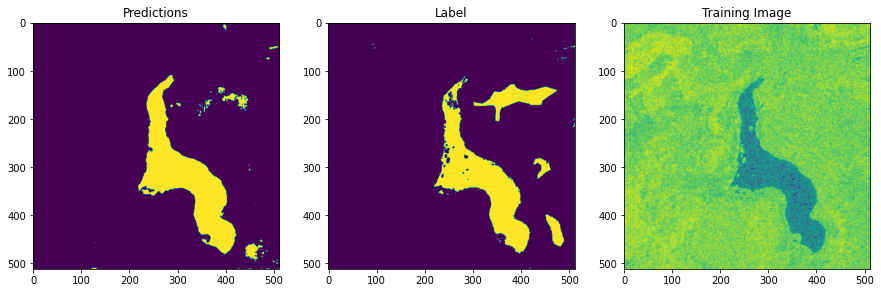

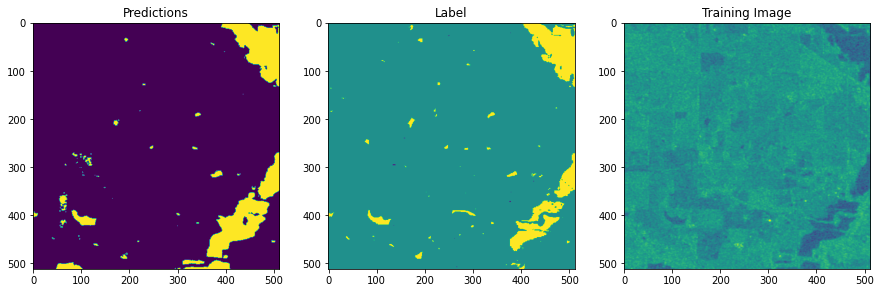

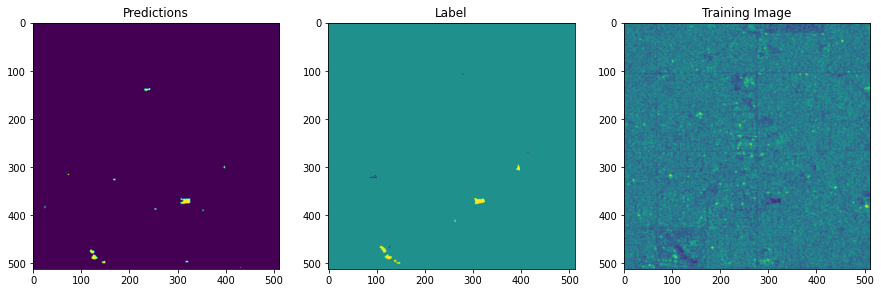

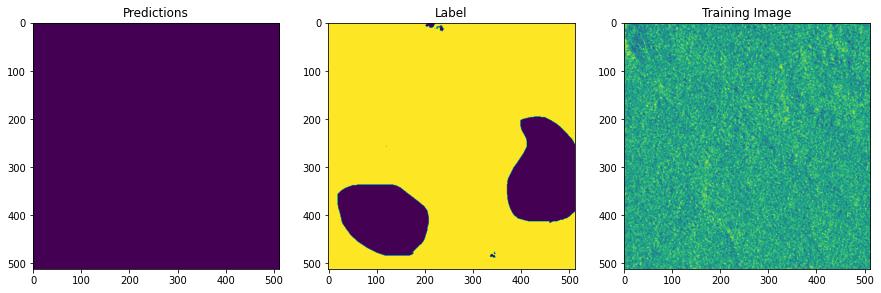

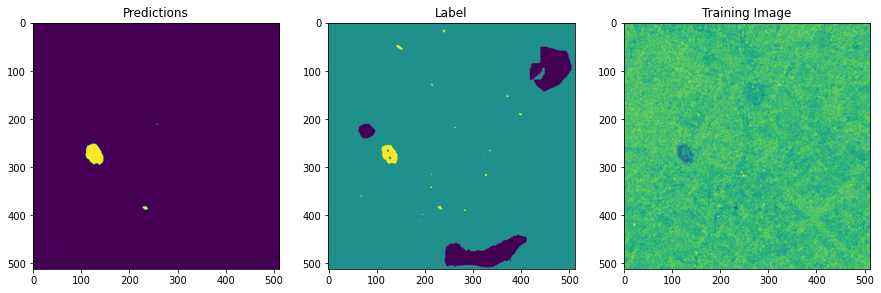

In [22]:
for i in range( 10):
  n = np.random.randint(1,144)

  # print(f"Inferecne Image Path {image_paths[n]}")
  # print(f"Inference Mask Path {mask_paths[n]}")
  infer_image = image_paths[n]
  infer_label = mask_paths[n]

  sample = np.moveaxis(tfl.imread(infer_image),0,2)
  threshold = 0.1
  pred_img = np.expand_dims(sample, axis = 0)
  val_preds = model.predict(pred_img)
  val_preds = np.squeeze(val_preds)
  val_preds = val_preds > threshold

  fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
  ax1.imshow(val_preds);
  ax1.set_title("Predictions")
  ax2.imshow(tfl.imread(infer_label));
  ax2.set_title("Label")
  ax3.imshow(tfl.imread(infer_image)[0]);
  ax3.set_title('Training Image')

  fig.savefig('Preds/Preds_'+str(i)+'.png')


In [29]:
!zip -r '/home/Preds.zip' '/home/Preds'

updating: home/Preds/ (stored 0%)
updating: home/Preds/Preds_6.png (deflated 3%)
updating: home/Preds/Preds_8.png (deflated 3%)
updating: home/Preds/Preds_4.png (deflated 3%)
updating: home/Preds/Preds_0.png (deflated 4%)
updating: home/Preds/Preds_1.png (deflated 3%)
updating: home/Preds/Preds_2.png (deflated 12%)
updating: home/Preds/Preds_9.png (deflated 3%)
updating: home/Preds/Preds_7.png (deflated 4%)
updating: home/Preds/Preds_5.png (deflated 3%)
updating: home/Preds/Preds_3.png (deflated 3%)
